In [1]:
from datasets import Dataset, load_dataset, DatasetDict, ClassLabel, concatenate_datasets
import numpy as np
import torch
import pandas as pd

#Seeding for deterministic results i.e. showing same output 
RANDOM_SEED = 64
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
   torch.cuda.manual_seed(RANDOM_SEED)
   torch.cuda.manual_seed_all(RANDOM_SEED) 
   torch.backends.cudnn.deterministic = True  
   torch.backends.cudnn.benchmark = False

/home/njfernandez/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
comfunctions_basic = 'comfunct_basic.txt'
df = pd.read_csv(comfunctions_basic, delimiter=";")
df = df[df['function'].isin(['ANGRY', 'WORRIED', 'PESSIMISTIC', 'DISLIKE', 'OTHER'])].rename(columns={"function": "functions"})
df

,text,functions
85,I'm not really very keen on it,DISLIKE
86,I'm not really very keen,DISLIKE
87,I'm not really keen on it,DISLIKE
88,I'm not really keen,DISLIKE
89,I'm not very keen on it,DISLIKE
...,...,...
897,you could do it,OTHER
898,you look nice,OTHER
899,you look smart,OTHER
900,you're right,OTHER


In [3]:
unique_labels = df["functions"].unique().tolist()
function_labels = ClassLabel(names=unique_labels)

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit([function_labels.names])
labels_classes = mlb.classes_
labels_classes

array(['ANGRY', 'DISLIKE', 'OTHER', 'PESSIMISTIC', 'WORRIED'],
      dtype=object)

In [4]:
function_mapping = {'OTHER': ['anticipation', 'joy', 'love', 'optimism', 'surprise', 'trust'],
           'NOT_INTERESTED': [''], 
           'DISLIKE':['disgust'], 
           'NOT_CORRECT': [''], 
           'PESSIMISTIC':['sadness', 'pessimism'], 
           'WORRIED':['fear'], 
           'ANGRY': ['anger'], 
           'DISAPPOINTED': [''], 
           'BORED': [''], 
           'NOT_APPROVE':[''], 
           'NOT_IMPORTANT': [''], 
           'DISAGREE': [''], 
           'WARN': [''], 
           'COMPLAIN': [''], 
           'THREATEN': [''], 
           'UNWILLING': [''], 
           'DISTRUST' : [''],
           'REFUSE': [''] }

ait_es_dataset = load_dataset("csv", sep = '\t', data_files ={'train': r'2018-E-c-Es-train.txt',
                                                        'test': r'2018-E-c-Es-test-gold.txt',
                                                       'valid': r'2018-E-c-Es-dev.txt'})
ait_en_dataset = load_dataset("csv", sep = '\t', data_files ={'train': r'2018-E-c-En-train.txt',
                                                        'test': r'2018-E-c-En-test-gold.txt',
                                                       'valid': r'2018-E-c-En-dev.txt'})
ait_ar_dataset = load_dataset("csv", sep = '\t', data_files ={'train': r'2018-E-c-Ar-train.txt',
                                                        'test': r'2018-E-c-Ar-test-gold.txt',
                                                       'valid': r'2018-E-c-Ar-dev.txt'})
train_dataset = concatenate_datasets([ait_es_dataset['train'], ait_en_dataset['train'], ait_ar_dataset['train']])
valid_dataset = concatenate_datasets([ait_es_dataset['valid'], ait_en_dataset['valid'], ait_ar_dataset['valid']])
test_dataset = concatenate_datasets([ait_es_dataset['test'], ait_en_dataset['test'], ait_ar_dataset['test']])

ait_dataset = DatasetDict({'train': train_dataset.shuffle(seed=42), 'valid': valid_dataset.shuffle(seed=42), 'test': test_dataset.shuffle(seed=42)})

Using custom data configuration default-051610f9ffe8f8d2
Found cached dataset csv (/home/njfernandez/.cache/huggingface/datasets/csv/default-051610f9ffe8f8d2/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
100%|██████████| 3/3 [00:00<00:00, 719.43it/s]
Using custom data configuration default-94907eb33ba58000
Found cached dataset csv (/home/njfernandez/.cache/huggingface/datasets/csv/default-94907eb33ba58000/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
100%|██████████| 3/3 [00:00<00:00, 639.70it/s]
Using custom data configuration default-869e6abb15784ff2
Found cached dataset csv (/home/njfernandez/.cache/huggingface/datasets/csv/default-869e6abb15784ff2/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
100%|██████████| 3/3 [00:00<00:00, 442.36it/s]
Loading cached shuffled indices for dataset at /home/njfernandez/.cache/huggingface/datasets/csv/default-051610f9ffe8f8d2/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f19

In [5]:
ait_dataset['test'][20]

{'ID': '2018-Ar-03597',
 'Tweet': 'انا رايحة اعمل عملية تانى فى عنيا\\nادعولى\\nوقلبى وربى غضبانين عليك يا اللى تفرط فى ارضك',
 'anger': 1,
 'anticipation': 0,
 'disgust': 0,
 'fear': 0,
 'joy': 0,
 'love': 0,
 'optimism': 0,
 'pessimism': 0,
 'sadness': 1,
 'surprise': 0,
 'trust': 0}

In [6]:
new_dataset = DatasetDict()
for split in ait_dataset:
    new_split = []
    for record in ait_dataset[split]:
        new_record = {'text': record['Tweet']}
        for function in function_mapping:
            labels = function_mapping[function]
            if '' in labels:
                continue
            else:
                score = sum([record[label] for label in labels])
                new_record[function] = int(score > 0)
        new_split.append(new_record)
    ait_dataset[split] =  Dataset.from_pandas(pd.DataFrame(data=new_split))

In [7]:
ait_dataset['test'][20]

{'text': 'انا رايحة اعمل عملية تانى فى عنيا\\nادعولى\\nوقلبى وربى غضبانين عليك يا اللى تفرط فى ارضك',
 'OTHER': 0,
 'DISLIKE': 0,
 'PESSIMISTIC': 1,
 'WORRIED': 0,
 'ANGRY': 1}

In [8]:
ait_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'OTHER', 'DISLIKE', 'PESSIMISTIC', 'WORRIED', 'ANGRY'],
        num_rows: 12675
    })
    valid: Dataset({
        features: ['text', 'OTHER', 'DISLIKE', 'PESSIMISTIC', 'WORRIED', 'ANGRY'],
        num_rows: 2150
    })
    test: Dataset({
        features: ['text', 'OTHER', 'DISLIKE', 'PESSIMISTIC', 'WORRIED', 'ANGRY'],
        num_rows: 7631
    })
})

In [9]:
cols = ait_dataset['test'].column_names
ait_dataset = ait_dataset.map(lambda x : {"functions": [c for c in cols if x[c] == 1]})
ait_dataset['test'][20]

100%|██████████| 7631/7631 [00:00<00:00, 14572.16ex/s]


{'text': 'انا رايحة اعمل عملية تانى فى عنيا\\nادعولى\\nوقلبى وربى غضبانين عليك يا اللى تفرط فى ارضك',
 'OTHER': 0,
 'DISLIKE': 0,
 'PESSIMISTIC': 1,
 'WORRIED': 0,
 'ANGRY': 1,
 'functions': ['PESSIMISTIC', 'ANGRY']}

In [10]:
# Convert labels to one hot enconding vectors
def one_hot_encoding(batch):
    label_ids = mlb.transform(batch['functions'])
    return {"label_ids":label_ids}
ait_dataset = ait_dataset.map(one_hot_encoding, batched=True)

100%|██████████| 8/8 [00:00<00:00, 257.76ba/s]


In [11]:
ait_dataset['test'][20]

{'text': 'انا رايحة اعمل عملية تانى فى عنيا\\nادعولى\\nوقلبى وربى غضبانين عليك يا اللى تفرط فى ارضك',
 'OTHER': 0,
 'DISLIKE': 0,
 'PESSIMISTIC': 1,
 'WORRIED': 0,
 'ANGRY': 1,
 'functions': ['PESSIMISTIC', 'ANGRY'],
 'label_ids': [1, 0, 0, 1, 0]}

In [12]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, Trainer, TrainingArguments
transformer_model = 'cardiffnlp/twitter-xlm-roberta-base'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = (AutoModelForSequenceClassification
         .from_pretrained(transformer_model,problem_type="multi_label_classification", num_labels = len(labels_classes))).to(device)
tokenizer=AutoTokenizer.from_pretrained(transformer_model)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding=True)

ds_enc = ait_dataset.map(tokenize, batched=True)
print(ds_enc)
ds_enc.set_format("torch", columns=["input_ids", "attention_mask", "label_ids"])
ds_enc = (ds_enc
          .map(lambda x : {"float_labels": x["label_ids"].to(torch.float)}, remove_columns=["label_ids"])
          .rename_column("float_labels", "label_ids"))

Some weights of the model checkpoint at cardiffnlp/twitter-xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base and are newly initialized: ['classifier.den

DatasetDict({
    train: Dataset({
        features: ['text', 'OTHER', 'DISLIKE', 'PESSIMISTIC', 'WORRIED', 'ANGRY', 'functions', 'label_ids', 'input_ids', 'attention_mask'],
        num_rows: 12675
    })
    valid: Dataset({
        features: ['text', 'OTHER', 'DISLIKE', 'PESSIMISTIC', 'WORRIED', 'ANGRY', 'functions', 'label_ids', 'input_ids', 'attention_mask'],
        num_rows: 2150
    })
    test: Dataset({
        features: ['text', 'OTHER', 'DISLIKE', 'PESSIMISTIC', 'WORRIED', 'ANGRY', 'functions', 'label_ids', 'input_ids', 'attention_mask'],
        num_rows: 7631
    })
})


100%|██████████| 7631/7631 [00:03<00:00, 2076.76ex/s]


In [13]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
    
# source: https://jesusleal.io/2021/04/21/Longformer-multlabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):   
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions)) 
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1   
    y_true = labels
    f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'macro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_macro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [14]:
from transformers import TrainingArguments, Trainer

batch_size = 16
model_name = "baseline_finetuning"
training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=5,
        learning_rate = 2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_ratio=0.1,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        metric_for_best_model = "f1",
        load_best_model_at_end=True,
        save_total_limit = 1,        
        report_to='none',
    )

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=ds_enc["train"],
                  eval_dataset=ds_enc["valid"],                    
                  tokenizer=tokenizer,
                 )
trainer.train()

The following columns in the training set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: DISLIKE, ANGRY, functions, WORRIED, OTHER, PESSIMISTIC, text. If DISLIKE, ANGRY, functions, WORRIED, OTHER, PESSIMISTIC, text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
/home/njfernandez/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 12675
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1985
  Number of trainable parameters = 278047493
Y

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,No log,0.376662,0.676998,0.767868,0.499535
2,0.467500,0.339588,0.736341,0.803875,0.519070
3,0.327300,0.341047,0.742795,0.812228,0.535349
4,0.271200,0.351157,0.753104,0.819948,0.544651
5,0.271200,0.362160,0.748581,0.818603,0.542791


The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: DISLIKE, ANGRY, functions, WORRIED, OTHER, PESSIMISTIC, text. If DISLIKE, ANGRY, functions, WORRIED, OTHER, PESSIMISTIC, text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2150
  Batch size = 32
Saving model checkpoint to baseline_finetuning/checkpoint-397
Configuration saved in baseline_finetuning/checkpoint-397/config.json
Model weights saved in baseline_finetuning/checkpoint-397/pytorch_model.bin
tokenizer config file saved in baseline_finetuning/checkpoint-397/tokenizer_config.json
Special tokens file saved in baseline_finetuning/checkpoint-397/special_tokens_map.json
Deleting older checkpoint [baseline_finetuning/checkpoint-1588] due to args.save_total_limit
/home/njfernandez/.local/lib/python3.8/site-packages/torch/nn/parallel

TrainOutput(global_step=1985, training_loss=0.32733679322211506, metrics={'train_runtime': 927.1514, 'train_samples_per_second': 68.355, 'train_steps_per_second': 2.141, 'total_flos': 4076482186558044.0, 'train_loss': 0.32733679322211506, 'epoch': 5.0})

In [15]:
preds_output = trainer.predict(ds_enc['valid'])
print(preds_output.metrics)

The following columns in the test set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: DISLIKE, ANGRY, functions, WORRIED, OTHER, PESSIMISTIC, text. If DISLIKE, ANGRY, functions, WORRIED, OTHER, PESSIMISTIC, text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2150
  Batch size = 32
/home/njfernandez/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.35115671157836914, 'test_f1': 0.7531037464122079, 'test_roc_auc': 0.8199481131628639, 'test_accuracy': 0.5446511627906977, 'test_runtime': 8.9889, 'test_samples_per_second': 239.185, 'test_steps_per_second': 7.565}


In [16]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

macros, micros, macroprecision, macrorecall = [], [], [], []
y_true = np.array(ds_enc['valid']["label_ids"])
thresholds = np.linspace(0.1, 1, 100)
for threshold in thresholds:
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(preds_output.predictions))
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1    
    report = classification_report(y_true, y_pred, target_names=labels_classes, zero_division=0, output_dict=True)
    micros.append(report["micro avg"]["f1-score"])
    macros.append(report["macro avg"]["f1-score"])
    macroprecision.append(report['macro avg']['precision'])
    macrorecall.append(report['macro avg']['recall'])

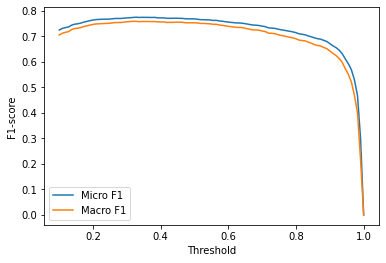

In [17]:
plt.plot(thresholds, micros, label="Micro F1")
plt.plot(thresholds, macros, label="Macro F1")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.show()

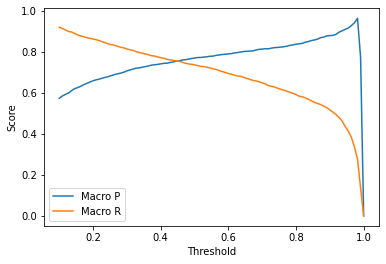

In [18]:
plt.plot(thresholds, macroprecision, label="Macro P")
plt.plot(thresholds, macrorecall, label="Macro R")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

In [19]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f'Best threshold (micro): {best_t} with F1-score {best_micro:.2f}.')
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f'Best threshold (macro): {best_t} with F1-score {best_macro:.2f}.')
best_t, best_macro_P = thresholds[np.argmax(macroprecision)], np.max(macroprecision)
print(f'Best threshold (macro-Precision): {best_t} with macroP-score {best_macro_P:.2f}.')
best_t, best_macro_R = thresholds[np.argmax(macrorecall)], np.max(macrorecall)
print(f'Best threshold (macro-Recall): {best_t} with macroR-score {best_macro_R:.2f}.')

Best threshold (micro): 0.32727272727272727 with F1-score 0.77.
Best threshold (macro): 0.32727272727272727 with F1-score 0.76.
Best threshold (macro-Precision): 0.9818181818181817 with macroP-score 0.96.
Best threshold (macro-Recall): 0.1 with macroR-score 0.92.


In [20]:
#output = trainer.evaluate()
preds_output = trainer.predict(ds_enc['test'])
print(preds_output.metrics)

The following columns in the test set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: DISLIKE, ANGRY, functions, WORRIED, OTHER, PESSIMISTIC, text. If DISLIKE, ANGRY, functions, WORRIED, OTHER, PESSIMISTIC, text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 7631
  Batch size = 32
/home/njfernandez/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.35369929671287537, 'test_f1': 0.7442200137324562, 'test_roc_auc': 0.8111359364041796, 'test_accuracy': 0.5299436508976543, 'test_runtime': 32.0219, 'test_samples_per_second': 238.305, 'test_steps_per_second': 7.464}


In [26]:
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(preds_output.predictions))
y_pred = np.zeros(probs.shape)
y_pred[np.where(probs >= 0.4)]= 1
y_true = np.array(ds_enc['test']["label_ids"])

from sklearn.metrics import classification_report

report = classification_report(
  y_true,
  y_pred,
  target_names=labels_classes,
  zero_division=0,
  output_dict=True
)
print(report)

df = pd.DataFrame(report).transpose()
with open(r'classification_report_baseline_ait_finetuning_multilabel_threshold=0.4.csv', 'w') as csv_file:
    df.to_csv(path_or_buf=csv_file)

{'ANGRY': {'precision': 0.7485359972442301, 'recall': 0.8265500190186382, 'f1-score': 0.7856109906001446, 'support': 2629}, 'DISLIKE': {'precision': 0.6473761647866602, 'recall': 0.7181719260065288, 'f1-score': 0.6809388702605107, 'support': 1838}, 'OTHER': {'precision': 0.8456410256410256, 'recall': 0.8379065040650406, 'f1-score': 0.8417559979581418, 'support': 3936}, 'PESSIMISTIC': {'precision': 0.7299925205684368, 'recall': 0.7253808992939428, 'f1-score': 0.7276794035414725, 'support': 2691}, 'WORRIED': {'precision': 0.7315891472868217, 'recall': 0.7003710575139147, 'f1-score': 0.7156398104265402, 'support': 1078}, 'micro avg': {'precision': 0.7569333758367868, 'recall': 0.7803154781465659, 'f1-score': 0.7684466019417475, 'support': 12172}, 'macro avg': {'precision': 0.7406269711054347, 'recall': 0.761676081179613, 'f1-score': 0.750325014557362, 'support': 12172}, 'weighted avg': {'precision': 0.7590605141456538, 'recall': 0.7803154781465659, 'f1-score': 0.7689560907295233, 'support

In [27]:
import torch.nn as nn
def loss_fn(outputs, labels):
    if labels is None:
        return None
    loss_values = []
    for f, b in zip(outputs, labels):
        loss_value = nn.BCEWithLogitsLoss()(f, b.float())
        loss_values.append(loss_value)
    torch_loss = torch.tensor(loss_values)
    return torch_loss

def forward_pass_with_label(batch): 
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}      
    with torch.no_grad():
        output = model(**inputs)
        logits = output.logits        
        sigmoid = torch.nn.Sigmoid()
        probs = sigmoid(logits.squeeze().cpu())       
        predictions = np.zeros(probs.shape)
        predictions[np.where(probs >= 0.5)] = 1       
        loss = loss_fn(logits, batch["label_ids"].to(device))
    return {"loss": loss.cpu().numpy(), 
            "pred_label_ids": predictions}

ds_enc.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label_ids"])
ds_enc = ds_enc.map(
    forward_pass_with_label, batched=True, batch_size = 8)

Parameter 'function'=<function forward_pass_with_label at 0x7f797ce2c3a0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
100%|██████████| 954/954 [00:18<00:00, 50.75ba/s]


In [28]:
def get_predicted_labels(batch):
    transformed_into_label_names = mlb.inverse_transform(np.array(batch['pred_label_ids']))  
    return  {"predicted_labels": list(map(list, transformed_into_label_names))}
ds_enc['test'] = ds_enc['test'].map(get_predicted_labels, batched=True)

ds_enc.set_format("pandas")
cols = ["text", "functions", "predicted_labels", "loss"]
df_test = ds_enc['test'][:][cols]
loss_values = df_test.sort_values("loss", ascending=False).head(50)
print(loss_values)

100%|██████████| 8/8 [00:00<00:00, 33.21ba/s]


                                                   text  \
3166  Was sort of hoping #EclipseDay would mean my w...   
4858  Estoy viendo rápido y furioso 8, sería más emo...   
4805  حلو شعور الكره المتبادل وتقابلو بعض بإبتسامة صفرة   
1767  Woke up to what appears to be either a sinus o...   
100   بجد ايه الكونسبت ال بيخليكى تقلعى الطرحه يوم خ...   
616   @ARnews1936 @kdsats72 Americans do not spank t...   
3228  @sailorm318 @LandonVegaXXX Where's the picture? 😰   
2331  Al principio estaba tentado, Ahora estoy enven...   
4821        Terrible playlist se armó el Mesa, lo banco   
6981  nag-iimprove na si Jasper omg 💙 dull boy no mo...   
4530  جيش التبولة اللبناني سيقوم بعملية مدروسة في جر...   
329   @allmmbi من جد انت متغير تغريداتك قلت. ومستوى ...   
154             عزيزي في هذا الشوب ريحتك اهم من مظهرك 😅   
3977  'A #nation is a #society #united by #delusions...   
238   واكثر شيء صدمني بالحلقة كان كلام رستم مع ابو ن...   
1802  كمية اشمئزاز عظيمة للشخص اللي يحس نفسه محور ال... 

In [29]:
loss_values.to_csv('loss_values_baseline_ait_finetuning_multilabel_threshold=0.4.tsv',header =True, sep = '\t',index=False)
df_test.to_csv('preds_baseline_ait_finetuning_multilabel_threshold=0.4.tsv',header =True, sep = '\t',index=False)